# Importing DICe data

Copyright 2021 Marco A. Lopez-Sanchez.  
Content under [Creative Commons Attribution license CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/), code under [Mozilla Public License 2.0](https://www.mozilla.org/en-US/MPL/2.0/).

> **Goal**: Learn how to import the DICe output and create a efficient data structure for fast and easy visualization

In [1]:
# Import neccesary libraries
import os
import numpy as np
import pandas as pd
from types import SimpleNamespace

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12, 8)

## Step 1: Load/import data

The first step requires to load the DICe output files. DICe generates one comma-separated tabular-like text file (.txt) for each image correlation performed so that if you correlate 10 images with a reference image you will get ten different text files plus others with information about the correlation performed. Each file also contains a variable number of columns, depending on the parameters you set to measure in DICe. Our goal in this Jupyter notebook is to explain how we are going to read these files from the hard disk and how we are going to store all this information for easy and efficient post-processing of the data. In summary, the tasks to code would be as follows:

- Read the text files from the hard disk
- Extract the parameters of interest from each file
- Store this information in an efficient data structure that allows us to visualise the evolution of each of the variables over time.

In addition to some standard Python modules, we will use the libraries [Pandas](), for reading the text files and extracting the parameters of interest, and [Numpy]() for storing the data efficiently. In particular, we are going to store the data in a numpy array object like the one shown below

![](https://github.com/marcoalopez/Jupyter4DICe/blob/main/notebooks/figs/NumPy_ndarrays_v2.png?raw=true)

where the numbers represent values of the parameter of interest, the axis 0 and 1 correspond to the y and x coordinates of the values in the maps, respectively, and the axis 2 to the different images taken.

> **DICe reference frame**: Image coordinates in DICe are measured from the top left corner of the image with x positive to the right and y positive downward. Rotations are positive clockwise (opposite of the right-hand rule).

---

In the following example we are going to create a loop that fins and reads all the txt files of the _dataset_ folder, extracts the displacement values in the x and y directions and the in-plane rotation and rearranges them as a data array, and finally save everything in the same variable to keep things tidy (do not fill the scope with too many variables).

In [2]:
path = 'dataset/'

# loop to extract the data
count = 1
print('Stacking data...')

for filename in os.listdir(path):
    if filename.startswith('DICe') and filename.endswith('.txt'):
        
        # load the corresponding txt file
        df = pd.read_csv(path + filename, delimiter=',')
        
        # separate the different parameters of interest and reorganize them as a matrix
        disp_X = df.pivot(index='COORDINATE_Y', columns='COORDINATE_X', values='DISPLACEMENT_X')
        disp_Y = df.pivot(index='COORDINATE_Y', columns='COORDINATE_X', values='DISPLACEMENT_Y')
        rot_Z = df.pivot(index='COORDINATE_Y', columns='COORDINATE_X', values='ROTATION_Z')

        
        # generate the numpy arrays
        if count == 1:
            dispX_stack = np.array(disp_X)
            dispY_stack = np.array(disp_Y)
            rotZ_stack = np.array(rot_Z)
            print(f'first processing file: {filename}')
            print('it might take a while...') 
        
        else:
            dispX_stack = np.dstack((dispX_stack, np.array(disp_X)))
            dispY_stack = np.dstack((dispY_stack, np.array(disp_Y)))
            rotZ_stack = np.dstack((rotZ_stack, np.array(rot_Z)))
        count += 1
        print('#', end = '')

print('')
print(f'last processing file: {filename}')
print('Done!')
print(f'Shape of arrays: {dispX_stack.shape}')

# remove variables that are not going to be used (to release RAM memory)
del df, count, filename, disp_X, disp_Y, rot_Z

Stacking data...
first processing file: DICe_solution_000.txt
it might take a while...
##########
last processing file: DICe_solution_074.txt
Done!
Shape of arrays: (377, 189, 10)


## Step 2: Understand the data structure

TODO

\[y coordinates, x coordinates, time steps]


In [3]:
data = SimpleNamespace(dispX=dispX_stack,
                       dispY=dispY_stack,
                       rotZ=rotZ_stack)

sorted(data.__dict__)

['dispX', 'dispY', 'rotZ']

In [4]:
type(data)

types.SimpleNamespace

## Step 3: Plot some data

As an example, let's plot the _in-plane_ rotation (rotation on the z axis) stored in the field named ``rotZ`` and the time step 10 (index 9). Since in DICe clockwise and counter-clockwise rotations are considered positive and negative respectively, we will illustrate them with a divergent colour map centred at 0 (i.e. areas with no rotation). In the chosen colour map, purple indicate clockwise rotations and green the opposite.

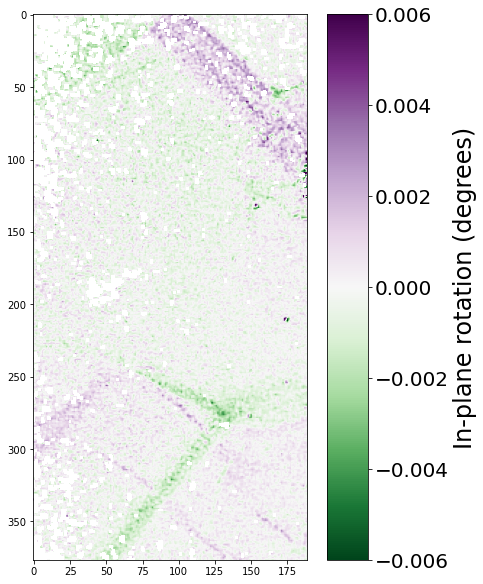

In [5]:
# initialize figure
fig, ax = plt.subplots(constrained_layout=True)

# image (take time step 10 --> [:, :, 9])
im = ax.imshow(data.rotZ[:, :, 9], vmin=-0.006, vmax=0.006, cmap='PRGn_r')

# add a color bar
cbar = fig.colorbar(im, ax=ax)
cbar.set_label('In-plane rotation (degrees)', fontsize=24)
cbar.ax.tick_params(labelsize=20)